In [60]:
clear

In [61]:
import pandas as pd
df=pd.read_csv('winequality-red.csv')

In [62]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [63]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [64]:
!pip3 install numpy pandas seaborn tqdm matplotlib torchvision sklearn

In [65]:
ls

CIFAR-10-Multi-Class-Classification-using-Pytorch-master/
CIFAR-10-Multi-Class-Classification-using-Pytorch-master.zip
e.g.ipynb
ggg.py
model_states/
multiclass_pytorch.ipynb
__pycache__/
pyt/
pyt.py
toolkit.py
winequality-red.csv


In [66]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

df=pd.read_csv('winequality-red.csv')
# print(df.head())

class2idx = {
    3:0,
    4:1,
    5:2,
    6:3,
    7:4,
    8:5
}

idx2class = {v: k for k, v in class2idx.items()}

df['quality'].replace(class2idx, inplace=True)

# print(df.head())


X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
# print(X.head())
# print(y.head())


X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)


X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)


scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)


def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['rating_3'] += 1
        elif i == 1: 
            count_dict['rating_4'] += 1
        elif i == 2: 
            count_dict['rating_5'] += 1
        elif i == 3: 
            count_dict['rating_6'] += 1
        elif i == 4: 
            count_dict['rating_7'] += 1  
        elif i == 5: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict



# plotting the data using seaborn

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# # Train
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# # Validation
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# # Test
# sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')


#neural network creation
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())




target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]


class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


class_weights_all = class_weights[target_list]


weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

# model_parameters
EPOCHS = 300
BATCH_SIZE = 16
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = 6

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          sampler=weighted_sampler
)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)


class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)


model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)



def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc) * 100
    
    return acc


accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}




print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
            
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


tensor([0.1429, 0.0263, 0.0020, 0.0022, 0.0070, 0.0714])
MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Begin training.


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 1.24268 | Val Loss: 1.41154 | Train Acc: 26.389| Val Acc: 46.875
Epoch 002: | Train Loss: 0.98355 | Val Loss: 1.34822 | Train Acc: 65.278| Val Acc: 42.969
Epoch 003: | Train Loss: 0.92032 | Val Loss: 1.36058 | Train Acc: 76.389| Val Acc: 40.625
Epoch 004: | Train Loss: 0.99137 | Val Loss: 1.31284 | Train Acc: 68.056| Val Acc: 47.656
Epoch 005: | Train Loss: 0.97132 | Val Loss: 1.44969 | Train Acc: 83.333| Val Acc: 41.406
Epoch 006: | Train Loss: 0.89589 | Val Loss: 1.34294 | Train Acc: 80.556| Val Acc: 43.750
Epoch 007: | Train Loss: 0.79453 | Val Loss: 1.35499 | Train Acc: 79.167| Val Acc: 38.281
Epoch 008: | Train Loss: 0.66729 | Val Loss: 1.37243 | Train Acc: 69.444| Val Acc: 42.188
Epoch 009: | Train Loss: 0.70884 | Val Loss: 1.27245 | Train Acc: 84.722| Val Acc: 43.750
Epoch 010: | Train Loss: 0.68988 | Val Loss: 1.31675 | Train Acc: 83.333| Val Acc: 43.750
Epoch 011: | Train Loss: 0.63094 | Val Loss: 1.24999 | Train Acc: 88.889| Val Acc: 46.094
Epoch 012:

Epoch 092: | Train Loss: 0.35947 | Val Loss: 1.23519 | Train Acc: 98.611| Val Acc: 50.000
Epoch 093: | Train Loss: 0.47490 | Val Loss: 1.33562 | Train Acc: 98.611| Val Acc: 51.562
Epoch 094: | Train Loss: 0.37782 | Val Loss: 1.27349 | Train Acc: 100.000| Val Acc: 52.344
Epoch 095: | Train Loss: 0.37600 | Val Loss: 1.29076 | Train Acc: 98.611| Val Acc: 51.562
Epoch 096: | Train Loss: 0.41487 | Val Loss: 1.27679 | Train Acc: 100.000| Val Acc: 52.344
Epoch 097: | Train Loss: 0.44001 | Val Loss: 1.32747 | Train Acc: 95.833| Val Acc: 43.750
Epoch 098: | Train Loss: 0.37605 | Val Loss: 1.30766 | Train Acc: 98.611| Val Acc: 51.562
Epoch 099: | Train Loss: 0.37105 | Val Loss: 1.27538 | Train Acc: 100.000| Val Acc: 50.000
Epoch 100: | Train Loss: 0.42363 | Val Loss: 1.33088 | Train Acc: 98.611| Val Acc: 51.562
Epoch 101: | Train Loss: 0.38933 | Val Loss: 1.23214 | Train Acc: 100.000| Val Acc: 54.688
Epoch 102: | Train Loss: 0.37291 | Val Loss: 1.39012 | Train Acc: 100.000| Val Acc: 49.219
Epoch

Epoch 183: | Train Loss: 0.32620 | Val Loss: 1.38327 | Train Acc: 100.000| Val Acc: 54.688
Epoch 184: | Train Loss: 0.32866 | Val Loss: 1.37419 | Train Acc: 98.611| Val Acc: 54.688
Epoch 185: | Train Loss: 0.33868 | Val Loss: 1.34363 | Train Acc: 98.611| Val Acc: 55.469
Epoch 186: | Train Loss: 0.36911 | Val Loss: 1.39445 | Train Acc: 100.000| Val Acc: 52.344
Epoch 187: | Train Loss: 0.36169 | Val Loss: 1.33804 | Train Acc: 100.000| Val Acc: 57.031
Epoch 188: | Train Loss: 0.28369 | Val Loss: 1.43668 | Train Acc: 100.000| Val Acc: 53.906
Epoch 189: | Train Loss: 0.33387 | Val Loss: 1.39454 | Train Acc: 98.611| Val Acc: 55.469
Epoch 190: | Train Loss: 0.32125 | Val Loss: 1.44073 | Train Acc: 100.000| Val Acc: 51.562
Epoch 191: | Train Loss: 0.35661 | Val Loss: 1.39994 | Train Acc: 97.222| Val Acc: 50.781
Epoch 192: | Train Loss: 0.27635 | Val Loss: 1.33493 | Train Acc: 100.000| Val Acc: 53.125
Epoch 193: | Train Loss: 0.30190 | Val Loss: 1.35884 | Train Acc: 100.000| Val Acc: 51.562
Epo

Epoch 274: | Train Loss: 0.25854 | Val Loss: 1.51499 | Train Acc: 100.000| Val Acc: 54.688
Epoch 275: | Train Loss: 0.32426 | Val Loss: 1.43713 | Train Acc: 98.611| Val Acc: 55.469
Epoch 276: | Train Loss: 0.27982 | Val Loss: 1.40246 | Train Acc: 100.000| Val Acc: 56.250
Epoch 277: | Train Loss: 0.26230 | Val Loss: 1.33493 | Train Acc: 100.000| Val Acc: 59.375
Epoch 278: | Train Loss: 0.30256 | Val Loss: 1.33388 | Train Acc: 100.000| Val Acc: 55.469
Epoch 279: | Train Loss: 0.25722 | Val Loss: 1.38100 | Train Acc: 100.000| Val Acc: 55.469
Epoch 280: | Train Loss: 0.28376 | Val Loss: 1.41199 | Train Acc: 100.000| Val Acc: 55.469
Epoch 281: | Train Loss: 0.29592 | Val Loss: 1.44426 | Train Acc: 100.000| Val Acc: 59.375
Epoch 282: | Train Loss: 0.29553 | Val Loss: 1.37864 | Train Acc: 100.000| Val Acc: 53.906
Epoch 283: | Train Loss: 0.24841 | Val Loss: 1.27118 | Train Acc: 100.000| Val Acc: 57.031
Epoch 284: | Train Loss: 0.31489 | Val Loss: 1.28936 | Train Acc: 100.000| Val Acc: 60.938


In [68]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

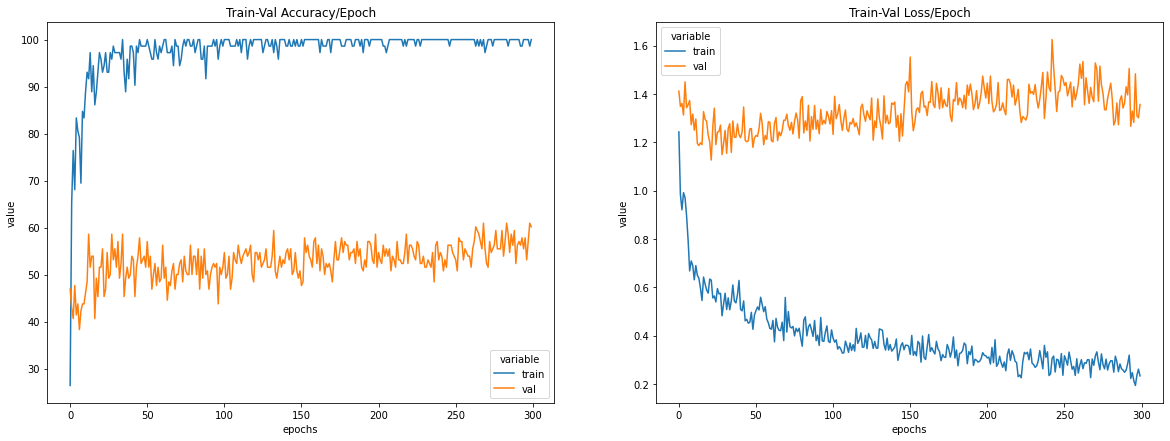

In [67]:
# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

<AxesSubplot:>

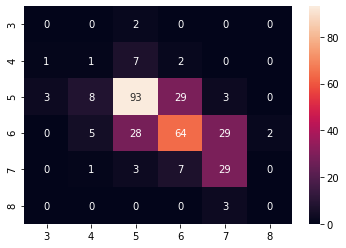

In [69]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)

sns.heatmap(confusion_matrix_df, annot=True)

In [70]:
print(classification_report(y_test, y_pred_list))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.07      0.09      0.08        11
           2       0.70      0.68      0.69       136
           3       0.63      0.50      0.56       128
           4       0.45      0.72      0.56        40
           5       0.00      0.00      0.00         3

    accuracy                           0.58       320
   macro avg       0.31      0.33      0.31       320
weighted avg       0.61      0.58      0.59       320



In [42]:
row = torch.Tensor([7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.5,9.4]).float()

In [74]:
model.eval()

MulticlassClassification(
  (layer_1): Linear(in_features=11, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=6, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [75]:
list(df.iloc[0,:-1])


[7.4, 0.7, 0.0, 1.9, 0.076, 11.0, 34.0, 0.9978, 3.51, 0.56, 9.4]

In [76]:
lst1=[7.3,0.65,0,1.2,0.065,15,21,0.9946,3.39,0.47,10]



In [77]:
new_data=torch.tensor(lst1)


In [78]:
with torch.no_grad():
    print(model(new_data))
    print(model(new_data).argmax().item())

ValueError: expected 2D or 3D input (got 1D input)